In [572]:
import numpy as np
import torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch import nn
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import torch.optim as optim

In [573]:
import game_environment as g

I coded a python file that records the logic and mechanics of minesweeper game in game_environment.py

In [581]:
def delete_arr(arr_list, target_array):
    for i in range(len(arr_list) - 1, -1, -1):
        if np.array_equal(arr_list[i], target_array):
            arr_list.pop(i)
            return
    print("awoooog")
    return
def init_game(width, height, mines):
    game = g.MinesweeperGame(width, height, mines)
    cells_remaining = []
    #inferred_safe = []
    inferred_mine = []
    priv_board_values = {}
    #remain_cells = np.zeros([height * width, 2])
    for i in range(height):
        for j in range(width):
            cells_remaining.append(np.array([j,i]))
            priv_board_values[j,i] = 9
    first_x = random.randint(0,width-1)
    first_y = random.randint(0,height-1)

    #game.print_board()
    #print("awooooooooga")
    #initial starting values

    game.initialize_mines(first_x, first_y)
    first_index = first_x,first_y
    priv_board_values[first_index] = game.reveal_cell(first_index[0], first_index[1])
    delete_arr(cells_remaining, first_index)
    return game, cells_remaining, priv_board_values

In [582]:
def infer_mines_and_safes(game, cells_remaining, priv_board_values):
    clue_number = {}  # To store the clue number for each revealed cell
    inferred_safe = set()  # Set to store inferred safe cells
    inferred_mine = set()  # Set to store inferred mine cells
    opened_cells = 0
    mines_triggered = 0
    total_cells = game.width * game.height
    non_mine_cells = total_cells - game.num_mines

    def infer(clue_number, cells_remaining, inferred_safe, inferred_mine):
        repeat = True
        processed_cells = set()  # Track cells that have already been processed

        while repeat:
            repeat = False
            for (x, y), clue in clue_number.items():
                if (x, y) in processed_cells:
                    continue  # Skip cells that have already been processed
                processed_cells.add((x, y))

                # Find neighboring cells
                neighbors = [(x + dx, y + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx, dy) != (0, 0)]
                # Filter for unrevealed and inferred cells using tuple representations
                unrevealed = [cell for cell in neighbors if tuple(cell) in map(tuple, cells_remaining)]
                inferred_mines = [cell for cell in neighbors if tuple(cell) in inferred_mine]

                # If all unrevealed neighbors must be mines
                if clue - len(inferred_mines) == len(unrevealed):
                    for cell in unrevealed:
                        inferred_mine.add(tuple(cell))
                        cells_remaining = [c for c in cells_remaining if tuple(c) != tuple(cell)]
                    repeat = True

                # If all unrevealed neighbors must be safe
                elif (len(neighbors) - clue) - len([cell for cell in neighbors if tuple(cell) in inferred_safe]) == len(unrevealed):
                    for cell in unrevealed:
                        inferred_safe.add(tuple(cell))
                        cells_remaining = [c for c in cells_remaining if tuple(c) != tuple(cell)]
                    repeat = True

    count = 0
    while cells_remaining and opened_cells < non_mine_cells:
        # Choose an inferred safe cell or randomly pick from remaining cells
        if inferred_safe:
            x, y = inferred_safe.pop()
        else:
            rand_index = random.randint(0, len(cells_remaining) - 1)
            x, y = cells_remaining.pop(rand_index)

        result = game.reveal_cell(x, y)
        priv_board_values[(x, y)] = result

        if result == -1:
            mines_triggered += 1
            break  # End the game if a mine is revealed
        else:
            opened_cells += 1
            clue_number[(x, y)] = result
        #print(count)
        infer(clue_number, cells_remaining, inferred_safe, inferred_mine)
        count+=1
        #print(count)
    return opened_cells, mines_triggered
def check_win2(board, revealed, mines):
    total_cells = board.shape[0] * board.shape[1]
    total_safe_cells = total_cells- mines
    #revealed_safe_cells = np.sum(revealed & (board != -1))
    return revealed == total_safe_cells
def simulate_games(num_simulations, width, height, mines):
    boards = np.zeros((num_simulations, height, width), dtype=int)
    results = np.zeros((num_simulations, 3), dtype=int)  # columns: opened_cells, mines_triggered, win/loss
    win_loss_map = {True: 1, False: 0}  # Map True to 1 (win), False to 0 (loss)

    for i in range(num_simulations):
        # Initialize a new game
        game, cells_remaining, priv_board_values = init_game(width, height, mines)
        opened_cells, mines_triggered = infer_mines_and_safes(game, cells_remaining, priv_board_values)
        boards[i, :, :] = game.get_board()
        results[i, 0] = opened_cells
        results[i, 1] = mines_triggered
        results[i, 2] = win_loss_map[check_win2(boards[i,:,:],opened_cells,mines)]
        if(i % 1000 == 0):
            print("simulation: ", i)

    return boards, results


Here are some functions that I used to generate my data from the logic_bot. There were some mistakes with data generation so I had to modify some of the results of data after the fact. 

In [ ]:
num_simulations = 500000
boards, results = simulate_games(num_simulations, width=9, height=9, mines=10)
print(results)
np.save('boards.npy', boards)
np.savetxt('results.csv', results, delimiter=',', fmt='%d') 

num_simulations = 100000
boards_med, results_med = simulate_games(num_simulations, width=16, height=16, mines=40)
np.save('boards_med.npy', boards_med)  # Stores boards in a binary `.npy` file
np.savetxt('results_med.csv', results_med, delimiter=',', fmt='%d') 

num_simulations = 50000
boards_hard, results_hard = simulate_games(num_simulations, width=30, height=16, mines=99)
np.save('boards_hard.npy', boards_hard)  # Stores boards in a binary `.npy` file
np.savetxt('results_hard.csv', results_hard, delimiter=',', fmt='%d') 

num_simulations = 10000
width=30
mines = (int)(random.uniform(.05, .3) * width * width)
boards_randmines, results_randmines = simulate_games(num_simulations, width = width, height = width, mines=mines)
np.save('boards_randmines.npy', boards_randmines)  # Stores boards in a binary `.npy` file
np.savetxt('results_randmines.csv', results_randmines, delimiter=',', fmt='%d') 

num_simulations = 10000
width=random.randint(5,50)
mines = (int)(random.uniform(.15, .25) * width * width)
boards_randboard, results_randboard = simulate_games(num_simulations, width = width, height = width, mines=mines)
np.save('boards_randboard.npy', boards_randboard)  # Stores boards in a binary `.npy` file
np.savetxt('results_randboard.csv', results_randboard, delimiter=',', fmt='%d') 


I generated 500,000 games of easy, 100,000 games of medium, 50,000 games of hard, 10,000 games of random mines, and 10,000 games of random size and mines.

In [586]:
loaded_boards_easy = np.load('boards.npy')
loaded_results_easy = np.loadtxt('results.csv', delimiter=',', dtype=int)
loaded_boards_med = np.load('boards_med.npy')
loaded_results_med = np.loadtxt('results_med.csv', delimiter=',', dtype=int)
loaded_boards_hard = np.load('boards_hard.npy')
loaded_results_hard = np.loadtxt('results_hard.csv', delimiter=',', dtype=int)

In [592]:
for i in range(len(loaded_results_easy)):
    if loaded_results_easy[i, 0] == 71:
        loaded_results_easy[i, 2] = 1
np.savetxt('results_2.csv', loaded_results_easy, delimiter=',', fmt='%d') 
for i in range(len(loaded_results_med)):
    if loaded_results_med[i, 1] == 0:
        loaded_results_med[i, 2] = 1
np.savetxt('results_med2.csv', loaded_results_med, delimiter=',', fmt='%d') 
for i in range(len(loaded_results_hard)):
    if loaded_results_hard[i, 1] == 0:
        loaded_results_hard[i, 2] = 1
np.savetxt('results_hard2.csv', loaded_results_hard, delimiter=',', fmt='%d')


Here is where I modified the csv files to ensure wins were counted correctly.

In [599]:
loaded_results_easy2 = np.loadtxt('results_2.csv', delimiter=',', dtype=int)
loaded_results_med2 = np.loadtxt('results_med2.csv', delimiter=',', dtype=int)
loaded_results_hard2 = np.loadtxt('results_hard2.csv', delimiter=',', dtype=int)

count_easy = 0
count_med = 0
count_hard = 0
for i in range(len(loaded_results_easy2)):
    if loaded_results_easy2[i, 2] == 1:
        count_easy += 1
for i in range(len(loaded_results_med2)):
    if loaded_results_med2[i, 2] == 1:
        count_med += 1
for i in range(len(loaded_results_hard2)):
    if loaded_results_hard2[i, 2] == 1:
        count_hard += 1
        
print("Easy logic bot results:", count_easy/len(loaded_results_easy2))
print("Med logic bot results:", count_med/len(loaded_results_med2))
print("Hard logic bot results:", count_hard/len(loaded_results_hard2))


Easy logic bot results: 0.017166
Med logic bot results: 0.00582
Hard logic bot results: 0.0037


Here we can see the results of the logic bot. Almost 2% win rate on the easy bot, .6% on the med bot, and .4% on the hard bot.

In [575]:
import numpy as np
import random
import game_environment as g
import torch
from torch import nn
import math

def to_coord(index, width):
    row = index // width
    col = index % width
    return row, col
def prob_bomb(probabilities, width, threshold=0.99):
    high_confidence_indices = np.where(probabilities > threshold)[0]  # Get indices of values above the threshold
    return to_coord(high_confidence_indices, width)
def get_best_move(probabilities, cells_remaining, width):
    cells_remaining_flat = []
    for coord in cells_remaining:
        cells_remaining_flat.append(coord[0] * width + coord[1])
    remaining_indices = torch.tensor(cells_remaining_flat, dtype=torch.long)
    filtered_probs = probabilities[remaining_indices]
    min_prob, min_rel_index = torch.min(filtered_probs, 0)
    min_index = remaining_indices[min_rel_index]
    min_prob = min_prob.item()

    max_prob, max_index = torch.max(probabilities, 0)
    max_prob = max_prob.item()

    # Use a hyperparameter threshold for flagging
    if max_prob < 0.9:
        return min_index.item(), max_index.item()
    else:
        return min_index.item(), -1
def create_input_channels(grid):
    height, width = grid.shape
    channels = 11  # 10 channels for values -1 to 9, and 1 for original values
    input_tensor = torch.zeros((channels, height, width), dtype=torch.float32)
    for i in range(height):
        for j in range(width):
            value = grid[i, j]
            if -1 <= value <= 9:
                input_tensor[int(value) + 1, i, j] = 1.0
            input_tensor[-1, i, j] = value

    return input_tensor
def dict_to_2d(dict, width, height):
    array = np.full((height, width), fill_value=np.nan)
    for (x, y), value in dict.items():
        array[y, x] = value
    return array
def twoD_to_1d(twod_arr):
    lst = []
    for row in twod_arr:
        for item in row:
            lst.append(item)
    return np.array(lst)
def create_reveal_mask(board):
    height, width = board.shape
    mask = np.zeros_like(board, dtype=int)
    revealed = board != 9
    for y in range(height):
        for x in range(width):
            if revealed[y, x]:
                mask[y, x] = 1
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < height and 0 <= nx < width:
                            mask[ny, nx] = 1
    return mask
def create_reveal_mask_v3(board):
    height, width = board.shape

    # Initialize the mask with zeros
    mask = np.zeros_like(board, dtype=int)

    # Loop through each cell to find "0" or "1" cells
    for y in range(height):
        for x in range(width):
            if board[y, x] == 0 or board[y, x] == 1:
                # Loop through neighboring cells
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        ny, nx = y + dy, x + dx
                        # Ensure the neighboring cell is within bounds
                        if 0 <= ny < height and 0 <= nx < width:
                            if board[ny, nx] == -1 or board[ny, nx] == 1:
                                # Map the original value (`1` or `-1`) to the mask
                                mask[ny, nx] = board[ny, nx]

    return mask
def resulting_array(arr1, arr2):
    result = np.zeros_like(arr1)
    result[arr1 == 1] = 1
    mask_negative = (arr2 == -1) & (arr1 == 0)
    result[mask_negative] = -1
    return result
def compare_flags(marked_mines, actual_mines):
    correct = np.sum((marked_mines == 10) & (actual_mines == 1))
    incorrect = np.sum((marked_mines == 10) & (actual_mines == 0))
    return correct, incorrect
def contains(lst, index_coord):
    for arr in lst:
        if np.array_equal(arr, index_coord):
            return True
    return False
def logic(model, game, priv_board_values, inProgress, cells_remaining, width = 9, height = 9, mines = 10):
    model.eval()
    if (not inProgress):
        game, cells_remaining, priv_board_values = init_game(width, height, mines)
        twod_priv_board = dict_to_2d(priv_board_values, width, height)
        unhidden_board_2d = game.get_board()
        #print(twod_priv_board)
        unhidden_mines_2d = ((unhidden_board_2d == -1) | (twod_priv_board == 9)).astype(int)
        unhidden_mines_1d = twoD_to_1d(unhidden_mines_2d)
        masked_hidden_board_2d = create_reveal_mask(twod_priv_board)
        mask_unhidden_mines_2d = ((masked_hidden_board_2d == 1) & ((unhidden_mines_2d) == 1)).astype(int)
        mask_unhidden_mines_1d = twoD_to_1d(mask_unhidden_mines_2d)
        win = game.check_win()
        return False, game, twod_priv_board, priv_board_values, unhidden_mines_1d, mask_unhidden_mines_1d, win, cells_remaining
        #inferred_mine = []
    #else:
        #cells_remaining = game.get_remaining_cells()
        #inferred_mine = game.get_flags()
        
    #revealed_cells = 1
    #bombs_flagged = 0
    twod_priv_board = dict_to_2d(priv_board_values, width, height)
    tensor_input = create_input_channels(twod_priv_board)  # Ensuring the data type is float
    tensor_input = tensor_input.unsqueeze(0)
    #print(tensor_input.shape)
    computed_array = model(tensor_input)
    #game.print_board()
    #for the real code, pass the board thru the model to obtain the computed array of probabilities
    index, flag_i = get_best_move(computed_array, cells_remaining, width)
    #print(index)
    #print(cells_remaining)
    index_coord = to_coord(index, width)
    if(contains(cells_remaining, index_coord)):
        priv_board_values[index_coord] = game.reveal_cell(index_coord[0], index_coord[1])
        delete_arr(cells_remaining, index_coord)
    #revealed_cells += 1
    #if flag_i > 0:
        #flag_coord = to_coord(flag_i, width)
        #game.flag_cell(flag_coord[0], flag_coord[1])
        #priv_board_values[flag_coord] = 10
        #inferred_mine.append(index_coord)
        #bombs_flagged += 1
        #print(priv_board_values)
    isOver = game.is_game_over()
    #print(twod_priv_board)
    win = game.check_win()
    #print(win)
    #final board as 2d arr
    twod_priv_board = dict_to_2d(priv_board_values, width, height)
    #final board as 1d arr
    oned_priv_board = twoD_to_1d(twod_priv_board)
    #unhidden board
    unhidden_board_2d = game.get_board()
    #unhidden board but only mines
    unhidden_mines_2d = (unhidden_board_2d == -1).astype(int)
    unhidden_mines_1d = twoD_to_1d(unhidden_mines_2d)
    #1s and 0s for border cells
    masked_hidden_board_2d = create_reveal_mask(twod_priv_board)
    #unhidden mines within border cells
    mask_unhidden_mines_2d = ((masked_hidden_board_2d == 1) & ((unhidden_mines_2d) == 1)).astype(int)
    #unhidden mines within border cells 1D
    mask_unhidden_mines_1d = twoD_to_1d(mask_unhidden_mines_2d)
        
    #correct_flags, incorrect_flags = compare_flags(twod_priv_board, unhidden_mines_2d)
    return isOver, game, twod_priv_board, priv_board_values, unhidden_mines_1d, mask_unhidden_mines_1d, win, cells_remaining
def logic2(model, game, priv_board_values, inProgress, cells_remaining, width = 9, height = 9, mines = 10):
    if (not inProgress):
        game, cells_remaining, priv_board_values = init_game(width, height, mines)
        twod_priv_board = dict_to_2d(priv_board_values, width, height)
        unhidden_board_2d = game.get_board()
        unhidden_mines_2d = np.zeros_like(unhidden_board_2d, dtype=int)
        unhidden_mines_2d[unhidden_board_2d == -1] = 1
        unhidden_mines_2d[twod_priv_board == 9] = -1
        #print(twod_priv_board)
        #print(unhidden_mines_2d)
        unhidden_mines_1d = twoD_to_1d(unhidden_mines_2d)
        masked_hidden_board_2d = create_reveal_mask(twod_priv_board)
        mask_unhidden_mines_2d = ((masked_hidden_board_2d == 1) & ((unhidden_mines_2d) == 1)).astype(int)
        mask_unhidden_mines_1d = twoD_to_1d(mask_unhidden_mines_2d)
        #print(mask_unhidden_mines_2d)
        mask_unhidden_mines_2d_unclicked = ((masked_hidden_board_2d != 1) | ((unhidden_mines_2d) != -1)).astype(int) * -1
        mask_unhidden_mines_1d_unclicked = twoD_to_1d(mask_unhidden_mines_2d_unclicked)
        final_board_2d = resulting_array(mask_unhidden_mines_2d, mask_unhidden_mines_2d_unclicked)
        final_board_1d = twoD_to_1d(final_board_2d)
        win = game.check_win()
        return False, game, twod_priv_board, priv_board_values, unhidden_mines_1d, final_board_1d, win, cells_remaining
    twod_priv_board = dict_to_2d(priv_board_values, width, height)
    tensor_input = create_input_channels(twod_priv_board)  # Ensuring the data type is float
    tensor_input = tensor_input.unsqueeze(0)
    computed_array = model(tensor_input)
    
    index, flag_i = get_best_move(computed_array, cells_remaining, width)
    index_coord = to_coord(index, width)
    priv_board_values[index_coord] = game.reveal_cell(index_coord[0], index_coord[1])
    if(contains(cells_remaining, index_coord)):
        delete_arr(cells_remaining, index_coord)
    isOver = game.is_game_over()
    win = game.check_win()
    twod_priv_board = dict_to_2d(priv_board_values, width, height)
    oned_priv_board = twoD_to_1d(twod_priv_board)
    unhidden_board_2d = game.get_board()
    unhidden_mines_2d = np.zeros_like(unhidden_board_2d, dtype=int)
    unhidden_mines_2d[unhidden_board_2d == -1] = 1
    unhidden_mines_2d[twod_priv_board == 9] = -1
    
    unhidden_mines_1d = twoD_to_1d(unhidden_mines_2d)
    masked_hidden_board_2d = create_reveal_mask(twod_priv_board)
    mask_unhidden_mines_2d = ((masked_hidden_board_2d == 1) & ((unhidden_mines_2d) == 1)).astype(int)
    mask_unhidden_mines_1d = twoD_to_1d(mask_unhidden_mines_2d)
    mask_unhidden_mines_2d_unclicked = ((masked_hidden_board_2d != 1) | ((unhidden_mines_2d) != -1)).astype(int) * -1
    #mask_unhidden_mines_1d_unclicked = twoD_to_1d(mask_unhidden_mines_2d_unclicked)
    final_board_2d = resulting_array(mask_unhidden_mines_2d, mask_unhidden_mines_2d_unclicked)
    final_board_1d = twoD_to_1d(final_board_2d)
    #print(mask_unhidden_mines_2d)
    #print(mask_unhidden_mines_2d_unclicked)
    #print(final_board_2d)
    
    return isOver, game, twod_priv_board, priv_board_values, unhidden_mines_1d, final_board_1d, win, cells_remaining
    

These functions are the bulk of my logic for the bulk of my work. My original model computed probabilities, then outputted the most likely cell and ran the logic of selecting that cell. I also went through multiple iterations of trying to mask the label values. For example, first I tried to get the model to learn the label values directly. Then I tried to get it to learn just the mines, then just the mines that were borderin already-selected cells. I also tried to implement a higher loss penalty if the model tried to select cells that were outside of the "neighboring" cells.

In [576]:
def custom_loss(preds, targets, height, width, num_bombs):
    loss = torch.tensor(0.0, dtype=torch.float32)
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=False)
    for index in range(len(preds)):
        probability = preds[index]  # Directly use tensor value, no need to `.item()`
        target_value = targets[index]  # Directly use tensor value
        if target_value == 1:
            loss += probability * (height * width / num_bombs)
        elif target_value == -1:
            loss += probability * height * width
        else:
            loss += (1.0 - probability)

    return torch.tensor(loss, requires_grad=True)

I tried using this loss function to add weight to the model selecting a mine, or choosing to click on a cell far away from the already-revealed cells.

In [577]:
def custom_loss2(preds, targets, height, width, num_bombs, count):    
    scale_bombs = count / num_bombs
    #scale_bombs = 1
    scale_height_width = 10
    loss_positive = torch.sum(preds[targets == 1] * scale_bombs)
    loss_negative = torch.sum(preds[targets == -1] * scale_height_width)
    loss_neutral = torch.sum(1.0 - preds[(targets != 1) & (targets != -1)])

    # Aggregate the losses
    total_loss = loss_positive + loss_negative + loss_neutral

    return total_loss

Another iteration of the custom loss function where I tried to add a scaling penalty based on which stage of the game the model was at.

In [578]:
class CNNModelEasy(nn.Module):
  def __init__(self):
    super(CNNModelEasy, self).__init__()
    height = 9
    width = 9

    self.conv_layer_1 = nn.Conv2d(in_channels = 11, out_channels = 22, kernel_size = 4, stride = 1, padding = 1, bias=True)
    self.layer_norm_1 = nn.LayerNorm([22, height-1, width-1])    
    self.conv_layer_2 = nn.Conv2d(in_channels = 22, out_channels = 22, kernel_size = 4, stride = 1, padding = 2, bias=True)
    self.layer_norm_2 = nn.LayerNorm([22, height, width])
    self.conv_layer_3 = nn.Conv2d(in_channels = 22, out_channels = 22, kernel_size = 4, stride = 1, padding = 1, bias=True)
    self.layer_norm_3 = nn.LayerNorm([22, height-1, width-1])
    self.conv_layer_4 = nn.Conv2d(in_channels = 22, out_channels = 22, kernel_size = 4, stride = 1, padding = 2, bias=True)
    self.layer_norm_4 = nn.LayerNorm([22, height, width])
    self.dropout_4 = torch.nn.Dropout(0.5)


    self.linear_layer = torch.nn.Linear( in_features = height * width * 22, out_features = height * width, bias=True )

  def forward(self, input_tensor):
    output = self.conv_layer_1( input_tensor )
    output = nn.ReLU()( output )
    output = self.layer_norm_1( output )
    output = self.conv_layer_2( output )
    output = nn.ReLU()( output )
    output = self.layer_norm_2( output )
    output = self.conv_layer_3( output )
    output = nn.ReLU()( output )
    output = self.layer_norm_3( output )
    output = self.conv_layer_4( output )
    output = nn.ReLU()( output )
    output = self.layer_norm_4( output )
    output = self.dropout_4( output )

    output = output.flatten()
    output = self.linear_layer( output )    
    output = nn.Sigmoid()( output )
    #print(output)
    return output

First iteration of the CNN model. When I played minesweeper, I realized that sometimes I had to use information from cells that were at most in a 4 by 4 (although rarely sometimes even 5 by 5, but this may have been too complex for the model). I made 4 convolutional layers of kernel 4 by 4 for this first model. I also one-hot encoded the inputs so each board was trained on 11 channels, 9 for each possible clue number, 1 for mines, and 1 for every clue together. I also added layer_norm and dropout to help with training.

In [579]:
class CNNModelEasy2(nn.Module):
  def __init__(self):
    super(CNNModelEasy2, self).__init__()
    height = 9
    width = 9

    self.conv_layer_1 = nn.Conv2d(in_channels = 11, out_channels = 22, kernel_size = 4, stride = 1, padding = 1, bias=True)
    self.layer_norm_1 = nn.LayerNorm([22, height-1, width-1])    
    self.conv_layer_2 = nn.Conv2d(in_channels = 22, out_channels = 22, kernel_size = 4, stride = 1, padding = 2, bias=True)
    self.layer_norm_2 = nn.LayerNorm([22, height, width])
    self.conv_layer_3 = nn.Conv2d(in_channels = 22, out_channels = 22, kernel_size = 3, stride = 1, padding = 1, bias=True)
    self.layer_norm_3 = nn.LayerNorm([22, height, width])
    self.conv_layer_4 = nn.Conv2d(in_channels = 22, out_channels = 22, kernel_size = 1, stride = 1, padding = 0, bias=True)
    self.layer_norm_4 = nn.LayerNorm([22, height, width])
    self.dropout_4 = torch.nn.Dropout(0.5)


    self.linear_layer = torch.nn.Linear( in_features = (height) * (width) * 22, out_features = height * width, bias=True )

  def forward(self, input_tensor):
    output = self.conv_layer_1( input_tensor )
    output = nn.ReLU()( output )
    output = self.layer_norm_1( output )
    output = self.conv_layer_2( output )
    output = nn.ReLU()( output )
    output = self.layer_norm_2( output )
    output = self.conv_layer_3( output )
    output = nn.ReLU()( output )
    output = self.layer_norm_3( output )
    output = self.conv_layer_4( output )
    output = nn.ReLU()( output )
    output = self.layer_norm_4( output )
    output = self.dropout_4( output )

    output = output.flatten()
    output = self.linear_layer( output )    
    output = nn.Softmax()( output )
    #print(output)
    return output

In this model, I switched to 4 decreasing kernel sizes: 4x4, 4x4, 3x3, 1x1 because intuitively, sometimes passing through the board one cell at a time may be beneficial. Next I tried adding Softmax so the model would select the "best" possible cell.

In [580]:
class CNNModelEasy3(nn.Module):
    def __init__(self):
        super(CNNModelEasy3, self).__init__()
        height = 9
        width = 9
        self.conv_layer_1 = nn.Conv2d(in_channels=11, out_channels=22, kernel_size=4, stride=1, padding=1, bias=True)
        self.conv_layer_2 = nn.Conv2d(in_channels=22, out_channels=22, kernel_size=4, stride=1, padding=2, bias=True)
        self.conv_layer_3 = nn.Conv2d(in_channels=22, out_channels=22, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv_layer_4 = nn.Conv2d(in_channels=22, out_channels=22, kernel_size=1, stride=1, padding=0, bias=True)
        self.dropout_4 = nn.Dropout(0.5)
        self.linear_layer = nn.Linear(in_features=(height) * (width) * 22, out_features=height * width, bias=True)

    def forward(self, input_tensor):
        output = self.conv_layer_1(input_tensor)
        output = nn.ReLU()(output)
        output = self.conv_layer_2(output)
        output = nn.ReLU()(output)
        output = self.conv_layer_3(output)
        output = nn.ReLU()(output)
        output = self.conv_layer_4(output)
        output = nn.ReLU()(output)
        output = self.dropout_4(output)
        output = output.flatten()
        output = self.linear_layer(output)
        output = nn.Sigmoid()(output)
        
        return output

In this third model, I switched back to a sigmoid on the last layer.

In [505]:
def train_cnn (alpha, model, epochs, convergence, width, height):
    batch_size = 10
    bombs = 10
    cnn_optimizer = optim.Adam(model.parameters(), lr = alpha )
    #loss_function = torch.nn.CrossEntropyLoss()
    #pos_weight = torch.tensor([width * height/ (bombs)])
    #loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    in_progress = False
    game = None
    priv_board_values = None
    losses = []
    counts = []
    prev_loss = math.inf
    avg_loss = -1
    pseudo_batch = 1
    total_loss = 0
    count_2 = 0
    count = 0
    
    for epochs in range(epochs):
        model.train()
        isOver = False
        in_progress = False
        count = 0
        cells_remaining = None
        #rand = random.randint(0, 80)
        #while ((not isOver) or ((epochs%2 == 0) and (count <= width* height - 1 - bombs))):
        while ((not isOver)):
        #while (count <= width* height - 1):
            #isOver, game, twod_priv_board, priv_board_values, unhidden_mines_1d, mask_unhidden_mines_1d, _, cells_remaining = logic(model, game, priv_board_values, in_progress, cells_remaining)
            isOver, game, twod_priv_board, priv_board_values, unhidden_mines_1d, mask_unhidden_mines_1d, _, cells_remaining = logic2(model, game, priv_board_values, in_progress, cells_remaining)
            in_progress = True
            cnn_optimizer.zero_grad()
            input = create_input_channels(twod_priv_board)
            output = torch.from_numpy(mask_unhidden_mines_1d).float()
            input = input.unsqueeze(0)
                   
            logits = model( input )
            #print(logits)
            loss = custom_loss2( logits, output, height, width, bombs, count )
            loss.backward()
            cnn_optimizer.step()
            total_loss += loss.item()
            #print(total_loss)
            count+=1
            count_2+=1
            
            #if count >= 100:
                #break
            if(epochs == 998):
                print(input)
                print(logits)
                print(output)
        if pseudo_batch == batch_size:
            pseudo_batch = 0
            avg_loss = total_loss / (width * height * count * batch_size)
            losses.append(avg_loss)
            print(avg_loss)
            total_loss = 0
            avg_count = count_2 / batch_size
            counts.append(avg_count)
            count_2 = 0
        if epochs > 0 and abs(prev_loss - avg_loss) < convergence:
            print(f"Convergence reached after {epochs+1} epochs.")
            break
        pseudo_batch += 1
        
    return losses, model, counts
    

This is my main training function for my CNN. I would find the next best move for a board, pass it into another iteration, then calculate the loss for it. I started out without training on data from logic_bot, because I thought it would be benefical for the model learn on its own self-generated data. I honestly spent the most time on this. However, this training never worked and I think I wasted so much time on it. If I had more time, I would begin to train on the generated data from the logic_bot and see how well the model learns.

I had also played around with a lot of things in my training function. I tried training with games through til the end, no matter how many mines were actived. I tried only training until the model "lost", and then made the model begin training on a new game. However, none of this worked.

In [506]:
easy_model = CNNModelEasy()
easy_model2 = CNNModelEasy2()
easy_model3 = CNNModelEasy3()
losses_easy, easy_model, counts = train_cnn(0.0001, easy_model3, 1000, 0.000001, 9, 9)

1.4990110179977199
0.7747321366843303
0.29613445585156667
0.36645354020475135
0.45228481797314196
1.5377769518781592
0.22604376982759547
0.26482979235825715
0.16570309475424208
0.1154832764568492
0.8185420636777525
0.16528891429748757
0.6651899108768982
0.16714895340640848
1.391372012503353
0.61112093945099
0.3701468127343791
0.2991191725882273
0.22620096958877292
1.0197551075813702
0.5763411786821153
0.3087803706547197
0.784878080273852
0.7851867304907905
0.38518562935016776
0.5270236661895312
0.3376565827263726
0.18506188186598413
0.4201063839005835
2.5524709783954385
0.7125521647096171
0.80740863452723
1.6388914485036592
0.8370372488469253
0.2709878609504229
0.6435189829932318
0.316975423509692
0.24274719578248483
1.2555558381257235
0.24403309593148356
0.6097226099467572
1.5851850851082507
0.33179013464185925
1.2469139578901691
0.8567906138337689
0.1412895017527095
0.3964728219589018
0.21127573684409812
0.2719136703161546
1.047901372556333
0.2610426553155823
1.7679008348488514
0.417

Here is an example of my losses. At one point, the model seemed to be randomly choosing cells. The logits also appeared to have converged to a seemingly random assignment too.

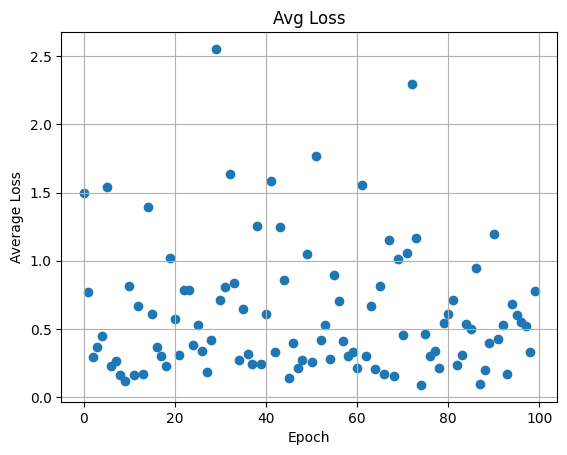

In [507]:
plt.scatter(range(len(losses_easy)), losses_easy, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Avg Loss')
plt.grid(True)
plt.show()

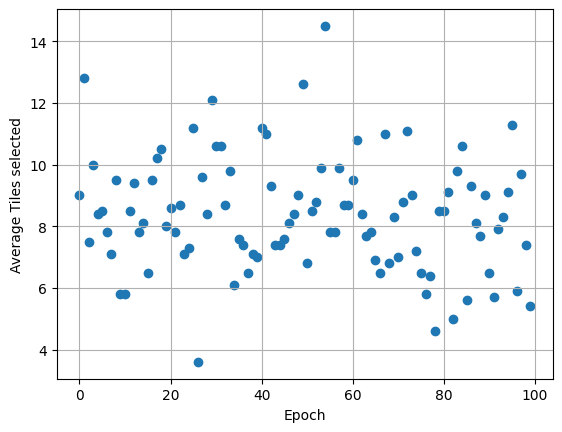

In [600]:
plt.scatter(range(len(counts)), counts, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Tiles selected')
plt.title('')
plt.grid(True)
plt.show()

Accordingly, the loss and average amount of tiles selected were near random.

In [354]:
def test_games(model, games):
    model.eval()
    cells_remaining_lens = []
    for epochs in range(games):
        isOver = False
        in_progress = False
        game = None
        game_count = 0
        win_count = 0
        priv_board_values = None
        cells_remaining = None
        
        while (not isOver):
            isOver, game, twod_priv_board, priv_board_values, unhidden_mines_1d, _, win, cells_remaining = logic(model, game, priv_board_values, in_progress, cells_remaining)
            in_progress = True
            #input = torch.from_numpy(twod_priv_board).float()
            #output = torch.from_numpy(mask_unhidden_mines_1d).float()
            #input = input.unsqueeze(0).unsqueeze(0)
            input = create_input_channels(twod_priv_board)
            input = input.unsqueeze(0)      
            logits = model( input )
            #print(logits)
            #print(twod_priv_board)
            #loss = loss_function( logits, output )
            #print(total_loss)
            lens = len(cells_remaining)
        if(win == True):
            win_count += 1
        game_count += 1
        win_rate = win_count / game_count
        cells_remaining_lens.append(lens)
        #losses.append([avg_loss])
    return win_rate, cells_remaining_lens

In [351]:
ratio, cells_remain = test_games(easy_model, 100)
print(ratio)
#print(cells_remain)

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 

This is my function for testing games after the model has been trained.

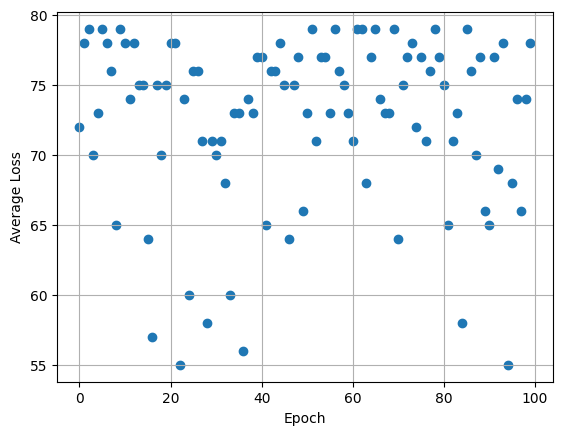

In [352]:
plt.scatter(range(len(cells_remain)), cells_remain, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('')
plt.grid(True)
plt.show()

Problem 2: Although I was unable to get this far in the assignment, I believe that the process for training and testing should be very similar to problem 1, although I predict the training to be slower and more volatile.

In [601]:
class CNNModelEasy4(nn.Module):
    def __init__(self, width2):
        super(CNNModelEasy4, self).__init__()
        height = 52
        width = 52
        self.conv_layer_1 = nn.Conv2d(in_channels=11, out_channels=22, kernel_size=4, stride=1, padding=2, bias=True)
        self.conv_layer_2 = nn.Conv2d(in_channels=22, out_channels=22, kernel_size=4, stride=1, padding=2, bias=True)
        self.conv_layer_3 = nn.Conv2d(in_channels=22, out_channels=22, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv_layer_4 = nn.Conv2d(in_channels=22, out_channels=22, kernel_size=1, stride=1, padding=0, bias=True)
        self.dropout_4 = nn.Dropout(0.5)
        self.linear_layer = nn.Linear(in_features=(height) * (width) * 22, out_features=width2 * width2, bias=True)

    def forward(self, input_tensor):
        output = self.conv_layer_1(input_tensor)
        output = nn.ReLU()(output)
        output = self.conv_layer_2(output)
        output = nn.ReLU()(output)
        output = self.conv_layer_3(output)
        output = nn.ReLU()(output)
        output = self.conv_layer_4(output)
        output = nn.ReLU()(output)
        output = self.dropout_4(output)
        output = output.flatten()
        output = self.linear_layer(output)
        output = nn.Sigmoid()(output)
        
        return output

Our new model4 has the same structure as our previous, excpet with one small variation. We take in inputs of 52x52, and then return a width x width length 1d array of probabilities.

In [602]:
def pad_and_count_mines(arr):
    padded_arr = np.pad(arr, pad_width=1, mode='constant', constant_values=0)
    border_count = np.zeros_like(padded_arr)
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    n_padded = padded_arr.shape[0]

    for i in [0, n_padded - 1]:
        for j in range(1, n_padded - 1):
            count = 0
            for dx, dy in directions:
                ni, nj = i + dx, j + dy
                if 0 <= ni < n_padded and 0 <= nj < n_padded and padded_arr[ni, nj] == -1:
                    count += 1
            border_count[i, j] = count

    for j in [0, n_padded - 1]:
        for i in range(1, n_padded - 1):
            count = 0
            for dx, dy in directions:
                ni, nj = i + dx, j + dy
                if 0 <= ni < n_padded and 0 <= nj < n_padded and padded_arr[ni, nj] == -1:
                    count += 1
            border_count[i, j] = count

    return border_count
def pad_to_52x52(array):
    current_shape = array.shape
    if len(current_shape) != 2 or current_shape[0] != current_shape[1]:
        raise ValueError("Input array should be a square 2D array.")
    
    n = current_shape[0]
    
    if n > 52:
        raise ValueError("Input array is already larger than 52x52.")
    pad_total = 52 - n
    pad_before = pad_total // 2
    pad_after = pad_total - pad_before
    padded_array = np.pad(
        array,
        pad_width=((pad_before, pad_after), (pad_before, pad_after)),
        mode='constant',
        constant_values=0
    )

    return padded_array

These two functions are key to my proposed model for Problem 3. Instead of feeding the model functions of variable length, I propose that I pad the cells by adding a 1 cell thick edge. To this edge, I will continue mine cell clue calcuation as prior. This way, the model will not be confused when learning edge cases. Next, I will add 0s to the boards until they become a standardized 52x52 in size so I can pass them into the neural network. This way, I can train boards of variable lenghth.

There are also some drawbacks with this, so I will also propose testing another model where the output is a 52x52 1d array directly, and playing the game as if each board is 52x52. However, this problem with this approach is that it will not learn to playing each game as it's "suppposed" to be played.

With the approach of padding the borders, I think it may also be a problem that the model does not learn that clues/mines on the border will have to be calculated differently. To alleviate this, maybe it is better to only pad two out of the four edges so that the other two will be trained as the game is "supposed" to be played. Instead, the model is currently being given a handicap and being asked to consider one less thing.

for me, I think the current state of the game should suffice for the network. When playing minesweeper myself, I realized that I could independently "solve" each stage, not unlike a chess puzzle. Therefore viewing the game sequentially may not be as important. However, I do find myself concentrating on a certain area of the board after making a certain move, so perhaps attention could be used in this aspect, to "smoothen out" the moves which are made on the board. 